In [1]:
import sys
sys.path.append('../')
from source.interference_reject import InterferenceReject
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [12]:
file_name = "../data/fse_brain_cormo_clean.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(num_channels_signal)
select_channels_noise = np.arange(num_channels_signal, num_channels_all)
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [13]:
data_scan = data['scan']

# Dynamic method: compute coefficients on the fly, in data bins
lines_per_bin = 100
num_lines_acq, num_channels, num_read = data_scan.shape
num_bins = int(np.ceil(num_lines_acq / lines_per_bin))
lines_per_bin = int(np.round(num_lines_acq / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [num_lines_acq - 1]))

# Spectral method only
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=select_channels_signal,
    channels_noise=select_channels_noise,
    num_freq_bins=matrix_size[0],
)
data_cor_all = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_all[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])

# First pass line-by-line e-sensor, then spectral
# data_first_pass = np.zeros((num_lines_acq, num_channels, num_read), dtype=np.complex64)
# weight_read = np.abs(np.linspace(-1, 1, num_read)) > 0.5
# weight_read_coil = np.tile(weight_read[:, np.newaxis], [1, num_channels_all])
# for _line in range(num_lines_acq):
#     line_signal = data_scan[_line, :, :]
#     line_sensor = data_scan[_line, 8, :]
#     c_esensor = np.dot(np.conj(line_sensor*weight_read), line_signal.T*weight_read_coil) / np.sum(np.abs(line_sensor*weight_read) ** 2)
#     data_first_pass[_line, :, :] = line_signal - np.dot(c_esensor[:, np.newaxis], line_sensor[:, np.newaxis].T)
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=select_channels_signal,
    channels_noise=select_channels_noise[1:],
    num_freq_bins=matrix_size[0],
)
data_cor_esensor = np.zeros((num_lines_acq, num_channels_signal, num_read), dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor_esensor[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])


## Plot k-space

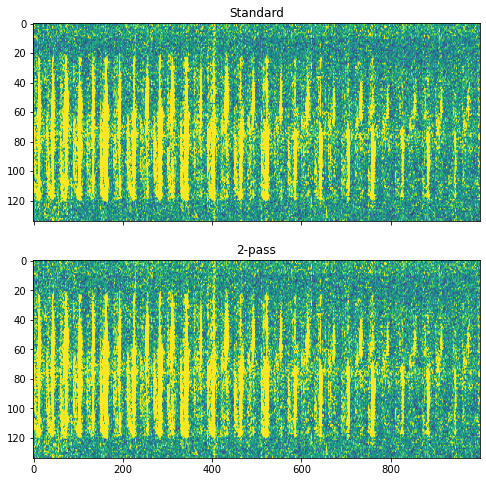

In [14]:
# Apply readout FT
spec_cor_all = np.fft.fftshift(np.fft.fft(data_cor_all, axis=-1), axes=-1)
spec_cor_esensor = np.fft.fftshift(np.fft.fft(data_cor_esensor, axis=-1), axes=-1)

ch = 0
n_lines = 1000
max_k = np.max(np.abs(spec_cor_all))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,8))
ax[0].set_title("Standard")
ax[0].imshow(np.squeeze(np.abs(spec_cor_all[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/20)
ax[1].set_title("2-pass")
ax[1].imshow(np.squeeze(np.abs(spec_cor_esensor[:n_lines, ch, :])).T, aspect='auto', vmin=0, vmax=max_k/20)
# fig.savefig("methods_rejection_kspace.tif", dpi=600, format="tiff")

## Fourier reconstruction

In [15]:
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
img_cor_all = np.zeros(dims_4d, dtype=np.complex64)
img_cor_esensor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_cor_all.shape[-1]):
    img_cor_all[_f, :, :, :] = encode_op.adjoint(spec_cor_all[:, :, _f])
    img_cor_esensor[_f, :, :, :] = encode_op.adjoint(spec_cor_esensor[:, :, _f])

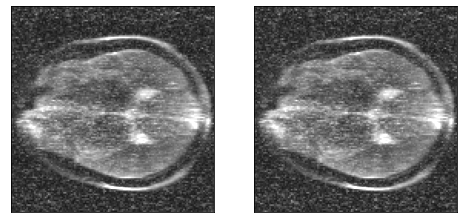

In [16]:
# Plot data
sos_cor_all = np.sqrt(np.sum(np.abs(img_cor_all) ** 2, axis=-1))
sos_cor_esensor = np.sqrt(np.sum(np.abs(img_cor_esensor) ** 2, axis=-1))

scaling = 3
slc = 17
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].imshow(np.abs(sos_cor_all[:, :, slc]), cmap='gray', vmin=0, vmax=scaling * np.mean(sos_cor_all))
ax[1].imshow(np.abs(sos_cor_esensor[:, :, slc]), cmap='gray', vmin=0, vmax=scaling * np.mean(sos_cor_all))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")

Interpolate dimension 0 from 134 to 138
Interpolate dimension 0 from 134 to 138


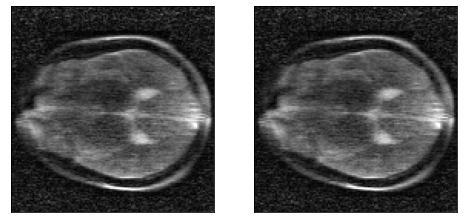

In [17]:
from source.combine import CoilCombo
# Get data for prewhitening using weighted k-space
wr = np.abs(np.linspace(-1, 1, data_cor_all.shape[-1]))
wr = wr / max(wr) > 0.9
wr = wr.astype(float)
wp = np.sqrt(np.sum(np.abs(k_2d) ** 2, axis=-1))
wp = wp / np.max(wp) > 0.9
wp = wp.astype(float)
w_all = np.dot(wr[:, np.newaxis], wp[:, np.newaxis].T)
w_all = np.transpose(np.tile(w_all[:, :, np.newaxis], num_channels_signal), [1, 2, 0])
data_weighted = data_cor_all * w_all
data_weighted_e = data_cor_esensor * w_all

comb_complex = CoilCombo(matrix_size=matrix_size, size_patch=[6, 6, 3])
im_adapt = comb_complex.forward(img_cor_all, data_noise=data_weighted, flag_prewhite=False, mode='adaptive')
im_adapt_e = comb_complex.forward(img_cor_esensor, data_noise=data_weighted_e, flag_prewhite=False, mode='adaptive')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].imshow(np.abs(im_adapt[:, :, slc]), cmap='gray', vmin=0, vmax=5 * np.mean(np.abs(im_adapt)))
ax[1].imshow(np.abs(im_adapt_e[:, :, slc]), cmap='gray', vmin=0, vmax=5 * np.mean(np.abs(im_adapt_e)))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])